In [79]:
'''
문제2)
https://github.com/pykwon/python/tree/master/data
자전거 공유 시스템 분석용 데이터 train.csv를 이용하여 대여횟`수에 영향을 주는 변수들을 골라 다중선형회귀분석 모델을 작성하시오.
모델 학습시에 발생하는 loss를 시각화하고 설명력을 출력하시오.
새로운 데이터를 input 함수를 사용해 키보드로 입력하여 대여횟수 예측결과를 콘솔로 출력하시오
'''

'\n문제2)\nhttps://github.com/pykwon/python/tree/master/data\n자전거 공유 시스템 분석용 데이터 train.csv를 이용하여 대여횟`수에 영향을 주는 변수들을 골라 다중선형회귀분석 모델을 작성하시오.\n모델 학습시에 발생하는 loss를 시각화하고 설명력을 출력하시오.\n새로운 데이터를 input 함수를 사용해 키보드로 입력하여 대여횟수 예측결과를 콘솔로 출력하시오\n'

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Input
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
cas

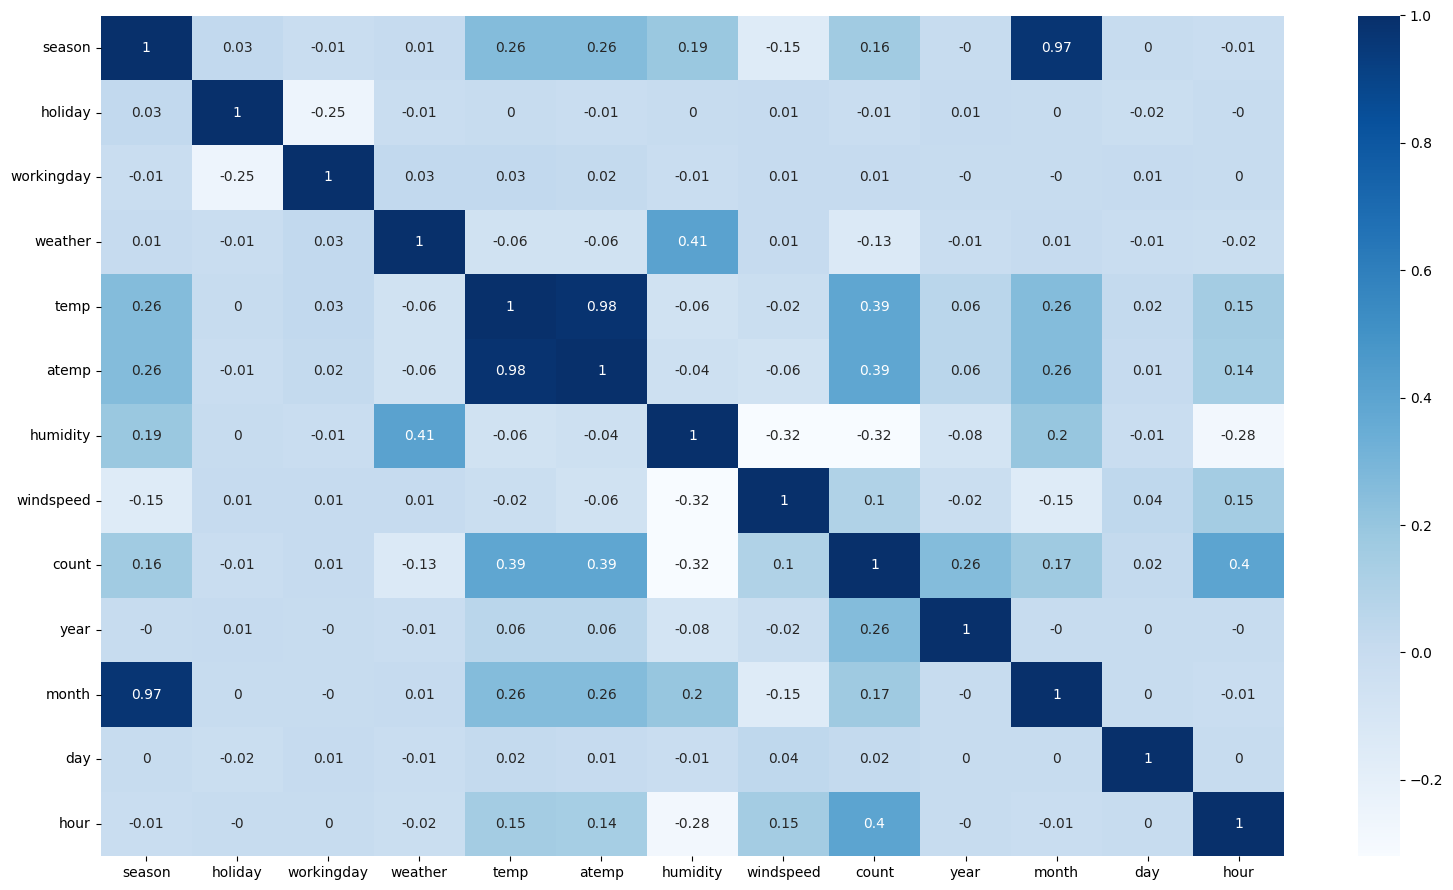

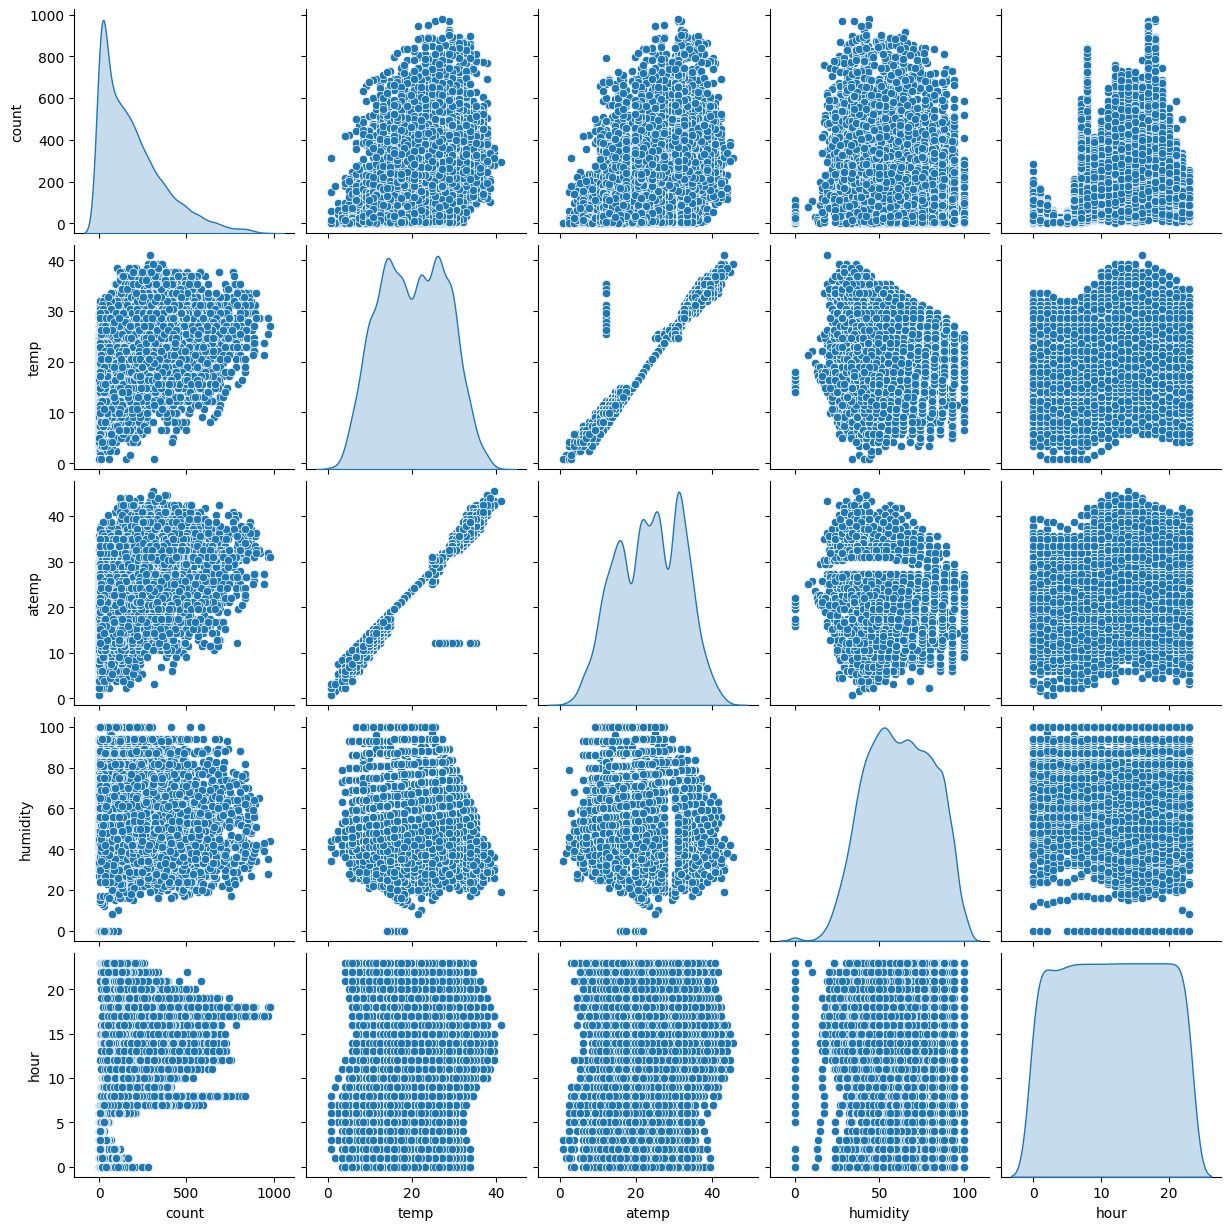

In [81]:
data = pd.read_csv('https://raw.githubusercontent.com/pykwon/python/refs/heads/master/data/train.csv',parse_dates=['datetime'])
# print(data.head(3))
data.info()
print(data.isna().sum())

data['year'] = data['datetime'].dt.year # 연월일시분초 칼럼 생성
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['minute'] = data['datetime'].dt.minute
data['second'] = data['datetime'].dt.second

print(data.head(3))

data.drop(['casual','registered', 'minute','second'], axis=1, inplace=True)

# 상관관계 확인
corr = data.corr(numeric_only=True).round(2)
print(corr)
plt.figure(figsize=(16,9))
sns.heatmap(corr, annot=True, cmap='Blues')
plt.tight_layout()
plt.show()
plt.close()

sns.pairplot(data[['count', 'temp','atemp','humidity','hour']], diag_kind='kde')
plt.show()

# feature 선정 : 'temp','atemp','humidity','hour'
features = data[['temp','atemp','humidity','hour']]
label = data[['count']]

In [82]:
# train / test split
x_train, x_test, y_train, y_test = train_test_split(features, label, train_size=0.3, random_state=23)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# 표준화
scaler = StandardScaler()
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.fit_transform(x_test)
print(x_train_sc[:2], x_test_sc[:2])

# 모델
def build_model():
    model = Sequential([
        Input(shape=x_train_sc.shape[1:],),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear'),
    ])
    opti = optimizers.Adam(learning_rate=0.001)
    model.compile(opti, loss='mse', metrics=['mse'])
    
    return model

model = build_model()
print(model.summary())

(3265, 4) (7621, 4) (3265, 1) (7621, 1)
[[ 0.54713215  0.77116514 -2.01315032  1.35411481]
 [-1.79246198 -1.6677605   1.24977788  1.35411481]] [[-0.58615903 -0.45616202 -0.82707368  0.50307096]
 [ 0.77621449  0.61256133  1.41055099 -1.52821321]]


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,249 (4.88 KB)

 Trainable params: 1,249 (4.88 KB)

 Non-trainable params: 0 (0.00 B)

None


In [83]:
# 조기 종료
early_stop = EarlyStopping(monitor='val_loss', baseline=0.03, patience=5)

# 학습
history = model.fit(x_train_sc, y_train, batch_size=32, epochs=5000, validation_split=0.2, callbacks=[early_stop])

Epoch 1/5000
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 68814.5156 - mse: 68814.5156 - val_loss: 69512.9141 - val_mse: 69512.9141
Epoch 2/5000
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 66668.2344 - mse: 66668.2344 - val_loss: 65830.6562 - val_mse: 65830.6562
Epoch 3/5000
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 59671.3945 - mse: 59671.3945 - val_loss: 56685.6523 - val_mse: 56685.6523
Epoch 4/5000
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 49694.9414 - mse: 49694.9414 - val_loss: 47733.0156 - val_mse: 47733.0156
Epoch 5/5000
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 42996.4727 - mse: 42996.4727 - val_loss: 43515.9062 - val_mse: 43515.9062
Epoch 6/5000
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 40787.7461 - mse: 40787.7461 - val_loss: 41730.3906 - val_mse: 41730.3906
Epoch 7/5000
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 39281.5547 - mse: 39281.5547 - val_loss: 39805.1680 - val_mse: 39805.1680
Epoch 8/5000
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 37

In [84]:
# 평가 evaluate
loss, mse = model.evaluate(x_test_sc, y_test)
print('test dataset으로 평가 loss : {:5.3f}'.format(loss))
print('test dataset으로 평가 mse : {:5.3f}'.format(mse))

print('결정계수 : ', r2_score(y_test, model.predict(x_test_sc)))

239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 23231.8125 - mse: 23231.8125
test dataset으로 평가 loss : 23231.812
test dataset으로 평가 mse : 23231.812
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
결정계수 :  0.2910023331642151


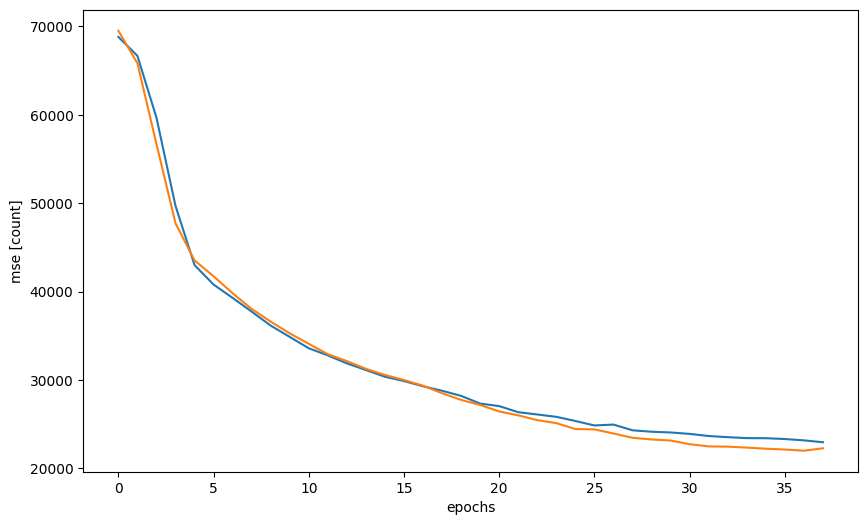

In [85]:
# 시각화
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plt.figure(figsize=(10,6))
plt.plot(hist['epoch'], hist['mse'], label='train err')
plt.plot(hist['epoch'], hist['val_mse'], label='validation err')
plt.xlabel('epochs')
plt.ylabel('mse [count]')
plt.show()
plt.close()


In [86]:
# 새로운 값으로 예측
temp_input = float(input('temp input :'))
atemp_input = float(input('atemp input : '))
humidity_input = int(input('humidity input :'))
hour_input = int(input('hour input : '))

new_data = pd.DataFrame({'temp' : [temp_input], 'atemp':[atemp_input], 'humidity':[humidity_input], 'hour':[hour_input]})

new_data_sc = scaler.fit_transform(new_data)
new_pred = model.predict(new_data_sc).ravel()
print('예측 결과 : ', new_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
예측 결과 :  [177.24292]
